# Implementation of K-means clustering and GMM for customer segmentation - A qualitative comparison


A synthetic dataset consisting of several customer groups, the only parameters viewed are their income and how much money they have spent. 

We will look at a K-means and a GMM (Gaussian Mixture Models) implementation.

A very simplified situation but this is more proof of concept, so we will not split up the data into train, validation and test sets. We will only look at qualitative comparisons and results.

In [1]:
## Imports
import numpy as np
import pandas as pd
import pylab as pb
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.mixture import GaussianMixture
from scipy import linalg
from matplotlib.patches import Ellipse

In [2]:
## Functions

def getCustomerGroup(mean,cov,noCustomers,seed=42):
    """Returns a numpyarray with customers using specified parameters from a Gaussian distribution.
    mean is a 1x2 vector with the mean of [income, spendings],
    cov  is a 2x2 vector with the covariance of the distribution,
    noCustomers is the numer of customers in this group.
    """
    np.random.seed(seed)
    income, spendings = np.random.multivariate_normal(mean,cov,noCustomers).T;
    return np.array([income,spendings]);
    

# Create the data.

We want several customer groups. Some with low income and low spending, some with high income high spending and a micture between these two.

In [3]:
## Create the data

seed = 42;

# Low income, Low spending
income = 210; spendings = 120; incomeVariance = 100; spendingsVariance = 100;

mean = [income,spendings];
cov  = [[incomeVariance, 0],
        [0, spendingsVariance]];
amountOfCustomers = 900;

lowIncome_lowSpending_Group = np.around(getCustomerGroup(mean, cov, amountOfCustomers),decimals=1);



# Low income, High spending
income = 200; spendings = 200; incomeVariance = 100; spendingsVariance = 130;

mean = [income,spendings];
cov  = [[incomeVariance, 0],
        [0, spendingsVariance]];
amountOfCustomers = 600;

lowIncome_highSpending_Group = np.around(getCustomerGroup(mean, cov, amountOfCustomers),decimals=1);


# Medium income, Medium spending
income = 230; spendings = 150; incomeVariance = 130; spendingsVariance = 180;

mean = [income,spendings];
cov  = [[incomeVariance, 0],
        [0, spendingsVariance]];
amountOfCustomers = 1500;

mediumIncome_mediumSpending_Group = np.around(getCustomerGroup(mean, cov, amountOfCustomers),decimals=1);


# High income, Low spending
income = 260; spendings = 150; incomeVariance = 100; spendingsVariance = 200;

mean = [income,spendings];
cov  = [[incomeVariance, 0],
        [0, spendingsVariance]];
amountOfCustomers = 400;

highIncome_lowSpending_Group = np.around(getCustomerGroup(mean, cov, amountOfCustomers),decimals=1);


# High income, High spending
income = 260; spendings = 260; incomeVariance = 100; spendingsVariance = 250;

mean = [income,spendings];
cov  = [[incomeVariance, 0],
        [0, spendingsVariance]];
amountOfCustomers = 700;

highIncome_highSpending_Group = np.around(getCustomerGroup(mean, cov, amountOfCustomers),decimals=1);


# Create pandas dataframe
customerGroups = pd.DataFrame(np.vstack((lowIncome_lowSpending_Group.T,  lowIncome_highSpending_Group.T,
                                         highIncome_lowSpending_Group.T, highIncome_highSpending_Group.T,
                                         mediumIncome_mediumSpending_Group.T)))

customerGroups.rename({0:'Income', 1:'Spendings',}, axis='columns',inplace=True)
customerGroups.index.names = ['Customer ID']

# Shuffle data for good meassure
customerGroups = shuffle(customerGroups)

print("\nExample of 5 customers at random.")
customerGroups.head()


Example of 5 customers at random.


,Income,Spendings
Customer ID,,
1992,267.1,256.5
2775,246.8,154.2
3029,237.2,142.6
545,209.3,119.6
132,207.5,107.5


# Visualization of the generated data-set

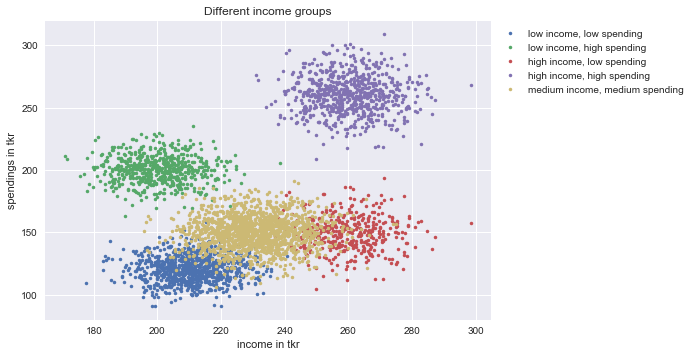



Information about the distribution of all groups together.



,count,mean,std,min,25%,50%,75%,max
Income,4100.0,229.650390,23.843991,171.0,210.7,227.1,249.025,298.5
Spendings,4100.0,169.870122,49.184374,90.8,134.3,153.6,199.700,308.7


In [4]:
## Plotting the data-set

pb.rcParams['figure.figsize'] = (13, 7)
pb.style.use('seaborn')

pb.plot(lowIncome_lowSpending_Group[0],  lowIncome_lowSpending_Group[1],
        '.', label="low income, low spending")

pb.plot(lowIncome_highSpending_Group[0], lowIncome_highSpending_Group[1],
        '.', label="low income, high spending")

pb.plot(highIncome_lowSpending_Group[0], highIncome_lowSpending_Group[1],
        '.', label="high income, low spending")

pb.plot(highIncome_highSpending_Group[0], highIncome_highSpending_Group[1],
        '.', label="high income, high spending")

pb.plot(mediumIncome_mediumSpending_Group[0], mediumIncome_mediumSpending_Group[1],
        '.', label="medium income, medium spending")

pb.xlabel('income in tkr'); pb.ylabel('spendings in tkr')
pb.title('Different income groups')
pb.legend(bbox_to_anchor=(1, 1))
pb.show()

## Display some information about the whole dataset

print("\n\nInformation about the distribution of all groups together.\n")
customerGroups.describe().T

# Visualization of the data-set we will work on

The labels of the different groups are now unknown.

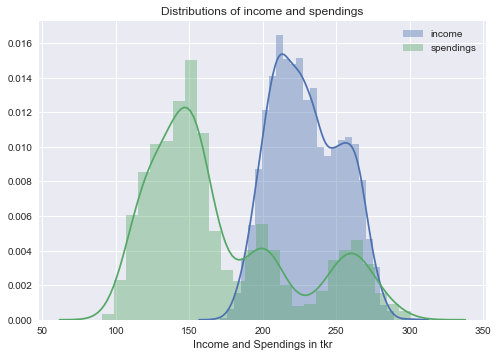

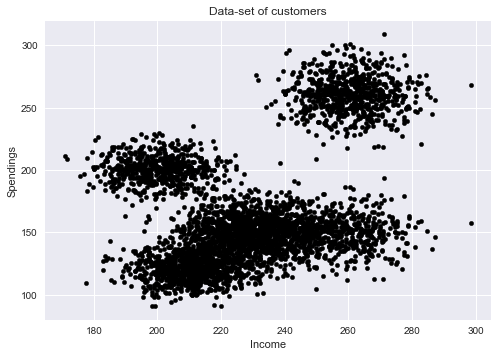

In [5]:
plot_income = sns.distplot(customerGroups["Income"],label="income")
plot_spend = sns.distplot(customerGroups["Spendings"],label="spendings")
pb.xlabel('Income and Spendings in tkr')
pb.title("Distributions of income and spendings")
pb.legend()
pb.show()

customerGroups.plot.scatter(x='Income',y='Spendings',c='Black')
pb.title("Data-set of customers")
pb.show()

# Finding optimal model parameters for k-means
Usually the amount of clusters needed is not clear, so we need to find the optimal amount of clusters. 
This does not always correspond to the underlying amount of clusters.

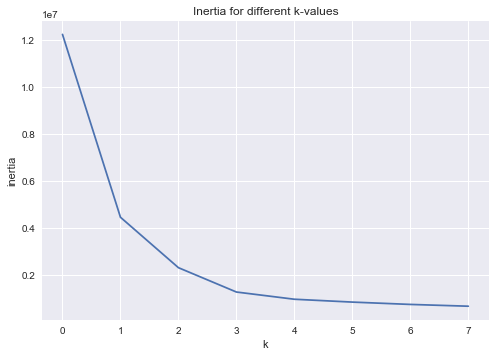


We can see that a value between 3-6 clusters seems like a good choice for this data-set. 
We can fit the model to these three values and see in the end which performs best based on a visual inspection.


In [6]:
## Find the best parameters (i.e. amount of clusters)

# Loop over several cases and check their inertia
inertia = []
for i in range(1,9):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(customerGroups)
    inertia.append(kmeans.inertia_)

pb.plot(inertia)
pb.title("Inertia for different k-values")
pb.xlabel("k")
pb.ylabel("inertia")
pb.show()

print("\nWe can see that a value between 3-6 clusters seems like a good choice for this data-set. \n"
      "We can fit the model to these three values and see in the end which performs best based on a visual inspection.")

# Fitting the model for k-means

We fit the kmeans by using three different k-values.

In [7]:
## Fit using differnt k-values

# k = 3
kmeans_3 = KMeans(n_clusters=3, random_state=42).fit(customerGroups)
labels_3 = kmeans_3.labels_

# k = 4
kmeans_4 = KMeans(n_clusters=4, random_state=42).fit(customerGroups)
labels_4 = kmeans_4.labels_

# k = 5
kmeans_5 = KMeans(n_clusters=5, random_state=42).fit(customerGroups)
labels_5 = kmeans_5.labels_

# k = 6
kmeans_6 = KMeans(n_clusters=6, random_state=42).fit(customerGroups)
labels_6 = kmeans_6.labels_

# Visualize the result for k-means

Show the result of the three models

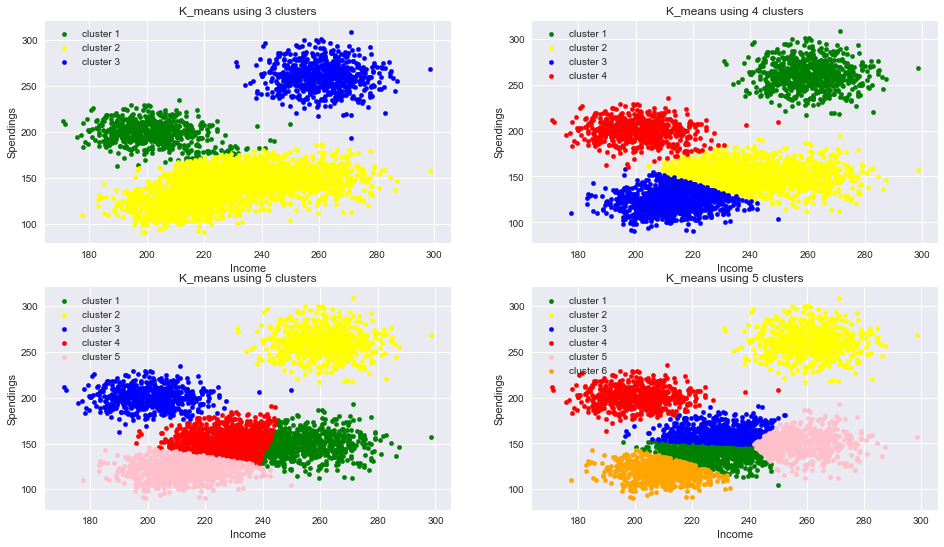



What is the best model can be argued. Even though the underlying distribution has 5 clusters, we can still see that using 6
clusters certainly is a viable solution since the variance within a group of customers can be large.


In [8]:
## Loop over k-values and plot a scatter plot

# Create colot map
COLORS = ["Green", "Yellow", "Blue", "Red", "Pink", "Orange"]

# k = 3
fig, ax = pb.subplots(2,2,figsize=(16,9))
for i in range(3):
    customerGroups[(labels_3.T==i)].plot.scatter(x='Income',y='Spendings',c=COLORS[i],
                                                 ax=ax[0,0], label="cluster {}".format(i+1))

ax[0,0].set_title("K_means using 3 clusters")


# k = 4
for i in range(4):
    customerGroups[(labels_4.T==i)].plot.scatter(x='Income',y='Spendings',c=COLORS[i],
                                                 ax=ax[0,1], label="cluster {}".format(i+1))

ax[0,1].set_title("K_means using 4 clusters")


# k = 5
for i in range(5):
    customerGroups[(labels_5.T==i)].plot.scatter(x='Income',y='Spendings',c=COLORS[i],
                                                 ax=ax[1,0], label="cluster {}".format(i+1))
    
ax[1,0].set_title("K_means using 5 clusters")


# k = 6
for i in range(6):
    customerGroups[(labels_6.T==i)].plot.scatter(x='Income',y='Spendings',c=COLORS[i],
                                                 ax=ax[1,1], label="cluster {}".format(i+1))

ax[1,1].set_title("K_means using 5 clusters")


pb.show()

print("\n\nWhat is the best model can be argued. Even though the underlying distribution has 5 clusters," 
      " we can still see that using 6\nclusters certainly is a viable solution since the variance within"
      " a group of customers can be large.")

## Possible marketing strategies using 6 clusters
*(Just a couple of ideas)*

One should marketing on the second (yellow) cluster of customers since they have both high income and are high spenders, whatever marketing is happening to them is successful.

The fifth cluster (pink) is a big possible source of extra income since they have a high income, but their low spending might originate from lack of interest of dissatisfaction with the website. Futher analysis could be done.

The third cluster (blue) have a low income but are generally high spenders. One could perhaps offer discount codes or the like to them.

Clusters one (green) and four (red) have about the same annual income, but the latter group spend less on the site, why? One could further analyze this group to gain more insight.

The last group, cluster six (orange) have low income and are low spenders. This might also be a good group for discount codes or other marketing strategies, but the problem might also lie in customer dissatisfaction. Needs more analysis.

# Finding optimal model parameters for GMM
In this case we look at the shape of the covariance as well as the number of classes as parameters.

In [9]:
## Find the optimal parameters by looping through a ot of possible figurations of covariance types and number of components.

covariance_types = ['spherical', 'diag', 'tied', 'full']
n_components = [3,4,5,6]
lowest_bic = np.infty

for cv in covariance_types:
    for n in n_components:
        
        # Create model, fit model and check BIC score.
        gmm = GaussianMixture(n_components=n, covariance_type=cv, max_iter=100, random_state=42)
        gmm.fit(customerGroups)
        tmp_bic = gmm.bic(customerGroups)
        if(tmp_bic<lowest_bic):
            lowest_bic = tmp_bic
            best_gmm = gmm
            
prediction_GMM = best_gmm.predict(customerGroups)

print("\nThe best model has " + repr(best_gmm.n_components) + " components and is using a " + 
      best_gmm.covariance_type + " covariance matrix.")


The best model has 5 components and is using a diag covariance matrix.


# Visualize results for GMM

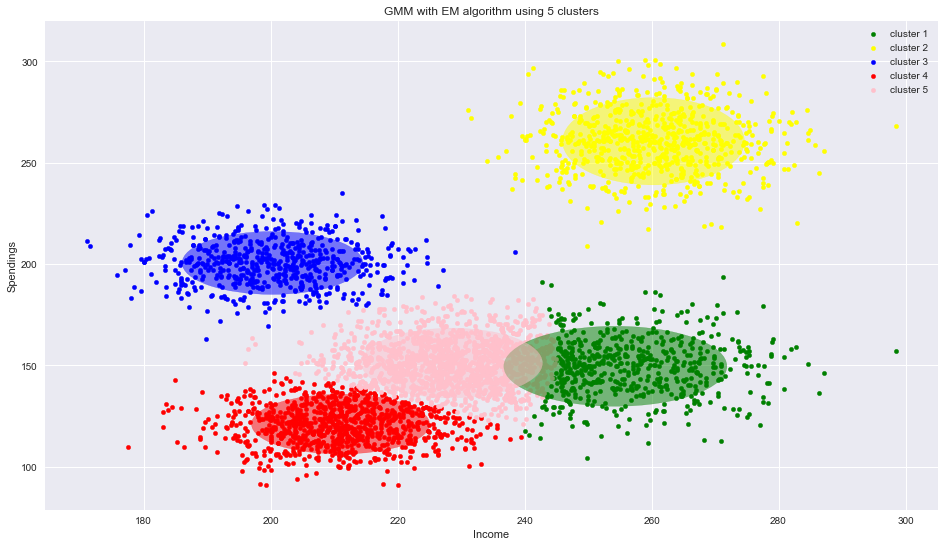


It is unsure about the two groups 'middle income, middle spendings' and 'high income, low spendings'.
If we look at the underlying distributions they also overlap there.


In [10]:
## Loop over the components and plot them as ellipses aswell as the classified data.

fig, ax = pb.subplots(1,1,figsize=(16,9))

for n in range(best_gmm.n_components):
    # Check what covariance we got as the optimal one
    if best_gmm.covariance_type == 'full':
        cov = best_gmm.covariances_[n][:2, :2]
    elif best_gmm.covariance_type == 'tied':
        cov = best_gmm.covariances_[:2, :2]
    elif best_gmm.covariance_type == 'diag':
        cov = np.diag(best_gmm.covariances_[n][:2])
    elif best_gmm.covariance_type == 'spherical':
        cov = np.eye(best_gmm.means_.shape[1]) * best_gmm.covariances_[n]
        
    mean = best_gmm.means_[n]
    # Get eigenvalues and eigenvectors for plotting the ellipses
    v, w = linalg.eigh(cov)
    
    # Scatter plot
    customerGroups[(prediction_GMM==n)].plot.scatter(x='Income',y='Spendings',c=COLORS[n],
                                                     ax = ax, label="cluster {}".format(n+1))

    # Plot an ellipse to show the gaussian distribution
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = Ellipse(mean, v[0], v[1], 180. + angle, color=COLORS[n])
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(.5)
    ax.add_artist(ell)

pb.title("GMM with EM algorithm using {} clusters".format(best_gmm.n_components))
pb.show()

print("\nIt is unsure about the two groups 'middle income, middle spendings' and 'high income, low spendings'"
      ".\nIf we look at the underlying distributions they also overlap there.")

# Qualitative comparison between the two algorithms

Comparison between K-means and GMM with 5 clusters.

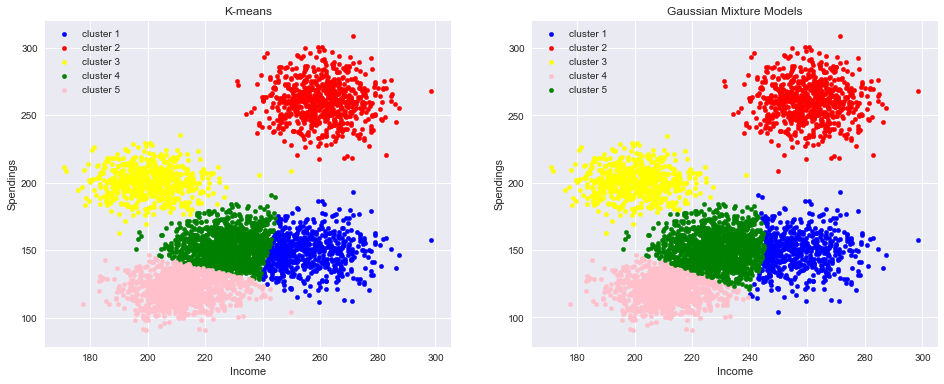


There is a slight difference between the two algorithms when it comes to the green, pink and blue clusters.
K-means assumes spherical clusters, so in this case it works pretty good.


In [11]:
## Scatter plot of customer group assignments.

fig, ax = pb.subplots(1,2,figsize=(16,6))
COLORS_Kmeans = ["Blue","Red","Yellow","Green","Pink"]
COLORS_GMM    = ["Blue","Red","Yellow","Pink" ,"Green"]

for i in range(5):
    customerGroups[(labels_5.T==i)].plot.scatter(x='Income',y='Spendings',c=COLORS_Kmeans[i],
                                                 ax=ax[0], label="cluster {}".format(i+1))
    
    customerGroups[(prediction_GMM==i)].plot.scatter(x='Income',y='Spendings',c=COLORS_GMM[i],
                                                     ax = ax[1], label="cluster {}".format(i+1))

ax[0].set_title("K-means")
ax[1].set_title("Gaussian Mixture Models")
pb.show()

print("\nThere is a slight difference between the two algorithms when it comes to the green, pink and blue clusters.\n"
      "K-means assumes spherical clusters, so in this case it works pretty good.")